In [1]:
# ================================
# Standard library
# ================================
import importlib
import os
import sys

# ================================
# Third-party libraries
# ================================
import joblib
import pandas as pd

# ================================
# Project configuration
# ================================
# Aggiungi la root del progetto al PYTHONPATH
sys.path.append(os.path.abspath(".."))


In [6]:
# Converts relative paths to absolute ones
ROOT_TRAIN_DATA_FOLDER ='data/raw/Data_Challenge_PHM2023_training_data'
ROOT_TEST_DATA_FOLDER = 'data/raw/Data_Challenge_PHM2023_test_data'

## Parsing

In [10]:
import utils.parsing
importlib.reload(utils.parsing)
from utils.parsing import parse_vibration_dataset, parse_test_dataset

df = parse_vibration_dataset(ROOT_TRAIN_DATA_FOLDER)
test_df = parse_test_dataset(ROOT_TEST_DATA_FOLDER)


Trovati 2016 file .txt da processare


Parsing dataset: 100%|██████████| 2016/2016 [08:02<00:00,  4.18file/s]



Ordinamento dataset...
Dataset caricato: 2016 file processati
Health levels disponibili: [0, 1, 2, 3, 4, 6, 8]
Condizioni operative (rpm): [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 2100, 2700, 3000, 3600]
Condizioni operative (torque): [50, 100, 200, 300, 400, 500]
Trovati 800 file .txt da processare


Parsing dataset: 100%|██████████| 800/800 [02:44<00:00,  4.87file/s]


Ordinamento dataset...
Dataset caricato: 800 file processati
Condizioni operative (rpm): [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3600]
Condizioni operative (torque): [50, 100, 200, 300, 400, 500]


In [11]:
df.to_pickle('data/processed/train_data.pkl')
test_df.to_pickle('data/processed/test_data.pkl')

In [ ]:
df

In [ ]:
test_df

## Downsampling

In [ ]:
df = pd.read_pickle('data/processed/train_data.pkl')

In [16]:
import utils.downsampling
importlib.reload(utils.downsampling)
from utils.downsampling import downsample_vibration_dataframe


features_df = downsample_vibration_dataframe(df, sec=3)

Preprocessing: 100%|██████████| 2016/2016 [00:00<00:00, 2381.90it/s]


In [ ]:
features_df.to_pickle('data/processed/train_data_dowsampled.pkl')

NameError: name 'features_df' is not defined

## Feature extraction

In [2]:
features_df = pd.read_pickle("data/processed/train_data_dowsampled.pkl")

In [3]:
# -----------------------
# Pulizia base target
# -----------------------
features_df['health_level'] = pd.to_numeric(features_df['health_level'], errors='coerce')
features_df = features_df.dropna(subset=['health_level']).reset_index(drop=True)

# -----------------------
# Definisci colonne
# -----------------------
scalar_cols = ['velocita', 'torque']  # numeriche scalari già pronte
array_cols = ['horizontal_acceleration', 'axial_acceleration', 'vertical_acceleration', 'tachometer_signal']

scalar_cols = [c for c in scalar_cols if c in features_df.columns]
array_cols  = [c for c in array_cols  if c in features_df.columns]

In [4]:
import utils.feature_extraction
importlib.reload(utils.feature_extraction)
from utils.feature_extraction import expand_features, remove_multicollinearity

print("[*] Genero feature...")
X_with_features = expand_features(features_df, array_cols=array_cols, scalar_cols=scalar_cols)
y = features_df['health_level'].astype(float).values

X_with_features, dropped_cols = remove_multicollinearity(X_with_features, threshold=0.85)

print(f"[*] Shape X_with_features: {X_with_features.shape}, n_features = {X_with_features.shape[1]}")

[*] Genero feature...

📊 Rimozione multi-collinearità (threshold=0.85)...
   • Features iniziali: 75
   • Features rimosse: 39
   • Features rimanenti: 36
[*] Shape X_with_features: (2016, 36), n_features = 36


In [5]:
X_with_features

,ax_median,ax_skew,ax_kurt,ax_band_0_200,ax_band_200_500,ax_band_500_1000,ax_band_1000_2000,ax_band_2000_4000,ay_median,ay_skew,...,corr_xz,corr_yz,ipi_mean,ipi_std,ipi_cv,v_times_t,v_sq,t_sq,v_over_rpm,t_over_rpm
0,-0.136461,-0.776361,0.005485,0.008149,0.010712,0.015578,0.009459,0.022354,-0.151264,-0.770164,...,0.976064,0.971404,1.082007,0.000659,0.000609,5000,10000,2500,1.666667,0.833333
1,0.003846,-0.272321,-0.881175,0.006527,0.011009,0.015855,0.009479,0.021377,0.003531,-0.277709,...,0.978543,0.979238,1.082153,0.000220,0.000203,5000,10000,2500,1.666667,0.833333
2,0.003598,-0.276468,-0.882501,0.005376,0.010446,0.014623,0.008646,0.022393,0.003885,-0.290422,...,0.979485,0.979838,1.081201,0.000000,0.000000,5000,10000,2500,2.500000,1.250000
3,0.003101,-0.275950,-0.891065,0.006446,0.009653,0.014769,0.009171,0.021920,0.003296,-0.285690,...,0.980113,0.980239,1.082666,0.000000,0.000000,5000,10000,2500,2.500000,1.250000
4,0.003722,-0.278965,-0.880287,0.007915,0.009939,0.014594,0.008473,0.022195,0.003767,-0.286163,...,0.980032,0.980720,1.082373,0.000195,0.000180,5000,10000,2500,1.666667,0.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,0.005645,-0.013527,0.140991,0.002078,0.004298,0.036616,0.042241,0.306010,0.040200,-0.079874,...,-0.013338,0.307308,0.030001,0.000024,0.000802,180000,12960000,2500,1.800000,0.025000
2012,0.001116,-0.021760,0.110431,0.001955,0.004792,0.035701,0.042614,0.307787,0.039552,-0.065825,...,-0.001688,0.304524,0.030002,0.000024,0.000807,180000,12960000,2500,1.800000,0.025000
2013,0.004094,0.018121,0.038303,0.000846,0.003244,0.027520,0.069767,0.468692,-0.272392,0.226129,...,0.066381,0.463836,0.030002,0.000024,0.000807,360000,12960000,10000,1.800000,0.050000
2014,0.003349,0.019681,0.091883,0.000803,0.003702,0.029189,0.074510,0.469177,-0.256501,0.229332,...,0.048462,0.418718,0.030001,0.000024,0.000804,360000,12960000,10000,1.800000,0.050000


## Training

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# -----------------------
# Split
# -----------------------
y_int = y.astype(int)
X = X_with_features.astype(np.float32).values

X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y_int
)


print(f"Dataset: {len(y)} campioni, {X.shape[1]} features, {len(set(y))} classi")
print(f"Split: Train={len(y_tr)}, Val={len(y_va)}")

Dataset: 2016 campioni, 36 features, 7 classi
Split: Train=1612, Val=404


In [7]:
import utils.model_class
importlib.reload(utils.model_class)
from utils.model_class import ModelSelectorClassification

# 3. Inizializza e addestra il selettore
selector = ModelSelectorClassification(
    scoring="f1_macro",  # Usa F1 macro per classi sbilanciate
    cv_folds=3,
    random_state=42
)

# 4. Training di tutti i modelli
selector.fit(X_tr, y_tr, X_with_features.columns.tolist())

TRAINING MODELLI (Classificazione)

[*] Tuning RandomForest...


Tuning RandomForest:   0%|          | 0/75 [00:00<?, ?it/s]

[+] Best F1_MACRO (cv) RandomForest: 0.9295
[+] Best params RandomForest:
{'model__class_weight': None,
 'model__max_depth': None,
 'model__max_features': 'log2',
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 600}

[*] Tuning HistGradientBoosting...


Tuning HistGradientBoosting:   0%|          | 0/75 [00:00<?, ?it/s]

[+] Best F1_MACRO (cv) HistGradientBoosting: 0.9262
[+] Best params HistGradientBoosting:
{'model__l2_regularization': 0.1,
 'model__learning_rate': 0.1,
 'model__max_depth': 8,
 'model__max_iter': 800,
 'model__min_samples_leaf': 30}

[*] Tuning XGBoost...


Tuning XGBoost:   0%|          | 0/90 [00:00<?, ?it/s]

[+] Best F1_MACRO (cv) XGBoost: 0.9167
[+] Best params XGBoost:
{'model__colsample_bytree': 0.9,
 'model__learning_rate': 0.05,
 'model__max_depth': 6,
 'model__n_estimators': 600,
 'model__reg_alpha': 0,
 'model__reg_lambda': 1.5,
 'model__subsample': 0.8}

[*] Tuning LightGBM...


Tuning LightGBM:   0%|          | 0/90 [00:00<?, ?it/s]

[+] Best F1_MACRO (cv) LightGBM: 0.9307
[+] Best params LightGBM:
{'model__class_weight': None,
 'model__colsample_bytree': 0.8,
 'model__learning_rate': 0.1,
 'model__max_depth': -1,
 'model__n_estimators': 600,
 'model__num_leaves': 31,
 'model__reg_alpha': 0,
 'model__reg_lambda': 0,
 'model__subsample': 0.9}

[*] Tuning GradientBoosting...


Tuning GradientBoosting:   0%|          | 0/75 [00:00<?, ?it/s]

[+] Best F1_MACRO (cv) GradientBoosting: 0.9398
[+] Best params GradientBoosting:
{'model__learning_rate': 0.1,
 'model__max_depth': 8,
 'model__max_features': 'sqrt',
 'model__n_estimators': 400,
 'model__subsample': 0.9}

[*] Tuning ExtraTrees...


Tuning ExtraTrees:   0%|          | 0/75 [00:00<?, ?it/s]

[+] Best F1_MACRO (cv) ExtraTrees: 0.9432
[+] Best params ExtraTrees:
{'model__class_weight': None,
 'model__max_depth': None,
 'model__max_features': 'log2',
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 600}

[*] Tuning RidgeClassifier...


Tuning RidgeClassifier:   0%|          | 0/30 [00:00<?, ?it/s]

[+] Best F1_MACRO (cv) RidgeClassifier: 0.4986
[+] Best params RidgeClassifier:
{'model__alpha': 0.1, 'model__class_weight': 'balanced'}

[*] Tuning LogReg_ElasticNet...


Tuning LogReg_ElasticNet:   0%|          | 0/45 [00:00<?, ?it/s]

[+] Best F1_MACRO (cv) LogReg_ElasticNet: 0.6643
[+] Best params LogReg_ElasticNet:
{'model__C': 10.0, 'model__class_weight': 'balanced', 'model__l1_ratio': 0.7}

RISULTATI FINALI - CONFRONTO MODELLI (Cross-Validation)
Modello              Best CV F1_MACRO   Std       
-------------------------------------------------------
RandomForest         0.9295             0.0073    
HistGradientBoosting 0.9262             0.0108    
XGBoost              0.9167             0.0120    
LightGBM             0.9307             0.0066    
GradientBoosting     0.9398             0.0011    
ExtraTrees           0.9432             0.0025    
RidgeClassifier      0.4986             0.0298    
LogReg_ElasticNet    0.6643             0.0310    

🏆 Miglior modello (CV): ExtraTrees (F1_MACRO: 0.9432 ± 0.0025)


In [8]:
# Valutazione su validation set
val_results = selector.evaluate_all(X_va, y_va)


VALUTAZIONE SU VALIDATION - TUTTI I MODELLI



=== RandomForest on validation ===
Accuracy:            0.9802
Balanced Accuracy:   0.9792
F1 Macro:            0.9800
F1 Weighted:         0.9802
ROC AUC:             0.9991

— Matrice di confusione (raw) – RandomForest
          pred_0.0  pred_1.0  pred_2.0  pred_3.0  pred_4.0  pred_6.0  pred_8.0
true_0.0        57         1         0         0         0         0         0
true_1.0         0        59         0         0         0         0         0
true_2.0         0         0        58         0         0         0         0
true_3.0         0         3         0        50         1         0         0
true_4.0         0         0         0         0        61         0         0
true_6.0         0         0         0         0         3         0         0
true_8.0         0         0         0         0         0        59         0

— Matrice di confusione (normalizzata per riga) – RandomForest
          pred_0.0  pred_1.0  pred_2.0  pred_3.0  pred_4.0  pred_6.0  pred_8.0
tru

In [9]:
# Feature importance
importances = selector.feature_importance(X_va, y_va, n_repeats=10, top_k=10)


[*] Calcolo permutation importance sul modello ExtraTrees...

Top 10 feature (permutation importance - f1_macro):
30    0.008731
10    0.006695
20    0.006217
25    0.005885
24    0.005481
3     0.004492
26    0.004476
34    0.003743
11    0.003464
14    0.003441
dtype: float64


In [12]:
# Salvataggio del miglior modello
model_path, metadata_path = selector.save_model()

# Caricamento modello salvato
loaded_model, metadata = selector.load_model(model_path, metadata_path)
print("\nMetadata caricati:", metadata)

Modello salvato con joblib in: models/best_model_classification_ExtraTrees_20250903_184117.joblib
Metadati salvati in: models/best_model_classification_metadata_ExtraTrees_20250903_184117.json
Modello caricato da: models/best_model_classification_ExtraTrees_20250903_184117.joblib

Metadata caricati: {'model_name': 'ExtraTrees', 'is_ensemble': False, 'scoring': 'f1_macro', 'accuracy': 0.9900990099009901, 'balanced_accuracy': 0.9894660894660895, 'f1_macro': 0.9899043985387717, 'f1_weighted': 0.9900836901595905, 'auc': 0.999678876557714, 'timestamp': '20250903_184117', 'best_params': {'model__n_estimators': 600, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 'log2', 'model__max_depth': None, 'model__class_weight': None}, 'classes': [0.0, 1.0, 2.0, 3.0, 4.0, 6.0, 8.0]}


In [10]:
# Creazione di un ensemble dei top 3
ensemble = selector.create_ensemble(top_n=3, voting='soft')

# Addestriamo l’ensemble sulle stesse feature
ensemble.fit(X_tr, y_tr)
print("\nAccuracy ensemble:", ensemble.score(X_va, y_va))


[*] Creato ensemble con soft voting dei top 3 modelli:
  • ExtraTrees
  • GradientBoosting
  • LightGBM

Accuracy ensemble: 0.9900990099009901


In [11]:
# Salvataggio del miglior modello
model_path_ensamble, metadata_path_ensamble = selector.save_model(ensemble, model_name="ensemble_model")

Modello salvato con joblib in: models/best_model_classification_ensemble_model_20250903_184055.joblib
Attenzione: non sono riuscito a calcolare le metriche sul validation set per ensemble_model. Motivo: y contains previously unseen labels: [8.]


TypeError: Object of type ExtraTreesClassifier is not JSON serializable

## Testing

In [13]:
test_df = pd.read_pickle('data/processed/test_data.pkl')

In [14]:
array_cols = ['horizontal_acceleration', 'axial_acceleration', 'vertical_acceleration', 'tachometer_signal']
scalar_cols = ['velocita', 'torque'] 
X_te = expand_features(test_df, array_cols=array_cols, scalar_cols=scalar_cols)
X_te = X_te.drop(columns=dropped_cols, errors='ignore')

In [15]:
best_model = joblib.load('models/best_model_classification_ensemble_model_20250903_184055.joblib')

In [16]:
import utils.testing_class
importlib.reload(utils.testing_class)
from utils.testing_class import TestingClass

gen = TestingClass(debug=True)   # debug=True per log più dettagliati

submission_df, diagnostics = gen.create_submission_simple(
    X_tr=X_tr,
    y_tr=y_tr,
    X_test=X_te,
    test_df=test_df,
    best_model=best_model,
    conf_thresh=0.5,       # soglia di confidence
    ordinal_smooth=0.2    # smoothing ordinale
)

# -------------------------
# Risultati
# -------------------------
print("Submission:")
submission_df

Model detected: VotingClassifier
Has scaler in pipeline: False
Requires scaling: False
Using RAW data for model predictions

=== DIAGNOSTICS ===

model_info:
{'name': 'VotingClassifier', 'has_scaler': False, 'requires_scaling': False, 'input_scaled': False}

detectors_info:
{'thresholds': {4: 0.02003315028603996, 6: 0.0188664904138649, 8: 0.014513829856696936}, 'n_detectors': 3}

tail_info:
{'strategy': 'adaptive', 'q85': 0.025478637467128994, 'q95': 4.504860026677271e-17, 'q99': -0.027386035375744577, 'mean': 0.08251335154599104, 'std': 0.043131412725069776}

transfers:
{'4_to_5': {'n_transfers': 8, 'total_moved': 2.2587486667195114, 'avg_alpha': 0.3764133501982634, 'alpha_range': '0.084-0.573'}, '6_to_7': {'n_transfers': 8, 'total_moved': 2.150342173851355, 'avg_alpha': 0.46233195626867374, 'alpha_range': '0.153-0.614'}, '8_to_10': {'n_transfers': 21, 'total_moved': 10.607232289978198, 'avg_alpha': 0.5913920044665761}, '8_to_9': {'n_transfers': 21, 'total_moved': 8.301864389314323, '

Submission:


,id,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9,prob_10,confidence
0,253,0.004922,0.001167,0.001189,0.074682,0.897695,1.867768e-02,4.167187e-09,3.333505e-05,1.600078e-03,3.333497e-05,0.000000,1
1,271,0.026089,0.938822,0.020911,0.013889,0.000289,4.135842e-10,4.231316e-09,3.799606e-10,1.400679e-08,2.918082e-10,0.000000,1
2,337,0.045729,0.014029,0.074868,0.006949,0.002792,5.638898e-05,2.636487e-05,6.420211e-03,3.188351e-01,5.196043e-01,0.010691,0
3,457,0.001633,0.000033,0.000344,0.036134,0.941143,1.959998e-02,1.443410e-09,2.222256e-05,1.066681e-03,2.222253e-05,0.000000,1
4,476,0.028844,0.940477,0.020856,0.009623,0.000200,4.421139e-10,4.478614e-09,3.866051e-10,1.407843e-08,2.933007e-10,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,264,0.002950,0.011159,0.040272,0.924171,0.020314,4.451929e-05,1.067463e-03,2.224530e-05,3.110974e-07,6.481195e-09,0.000000,1
796,424,0.057833,0.521482,0.061473,0.060053,0.061168,5.606791e-03,2.091613e-01,4.734818e-03,1.810996e-02,3.772909e-04,0.000000,0
797,453,0.017953,0.042808,0.049017,0.088864,0.157833,6.863919e-03,1.733989e-01,6.166714e-03,1.226033e-01,9.193006e-03,0.325300,0
798,506,0.024672,0.045168,0.037679,0.122449,0.145126,5.608658e-03,1.307382e-01,2.086243e-01,2.743063e-01,5.627753e-03,0.000000,0


### Results

CACHEDIR=C:\Users\dswal\.matplotlib
Using fontManager instance from C:\Users\dswal\.matplotlib\fontlist-v390.json
Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='c:\\Users\\dswal\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='c:\\Users\\dswal\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='c:\\Users\\dswal\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-BoldItal

ANALISI SUBMISSION
📊 STATISTICHE GENERALI:
   • Numero predizioni: 800
   • Normalizzazione: ✅ OK

📈 DISTRIBUZIONE PREDIZIONI:
   • Classe  0:     63 (  7.9%)
   • Classe  1:     84 ( 10.5%)
   • Classe  2:     57 (  7.1%)
   • Classe  3:     58 (  7.2%)
   • Classe  4:     66 (  8.2%)
   • Classe  6:    177 ( 22.1%)
   • Classe  7:      1 (  0.1%)
   • Classe  8:    270 ( 33.8%)
   • Classe  9:      9 (  1.1%)
   • Classe 10:     15 (  1.9%)

🔎 CONFIDENCE:
   • High: 556
   • Low : 244
   • Media: 69.5%


findfont: score(FontEntry(fname='c:\\Users\\dswal\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='c:\\Users\\dswal\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='c:\\Users\\dswal\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 1.05
findfont: score(FontEntry(fname='c:\\Users\\dswal\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.33

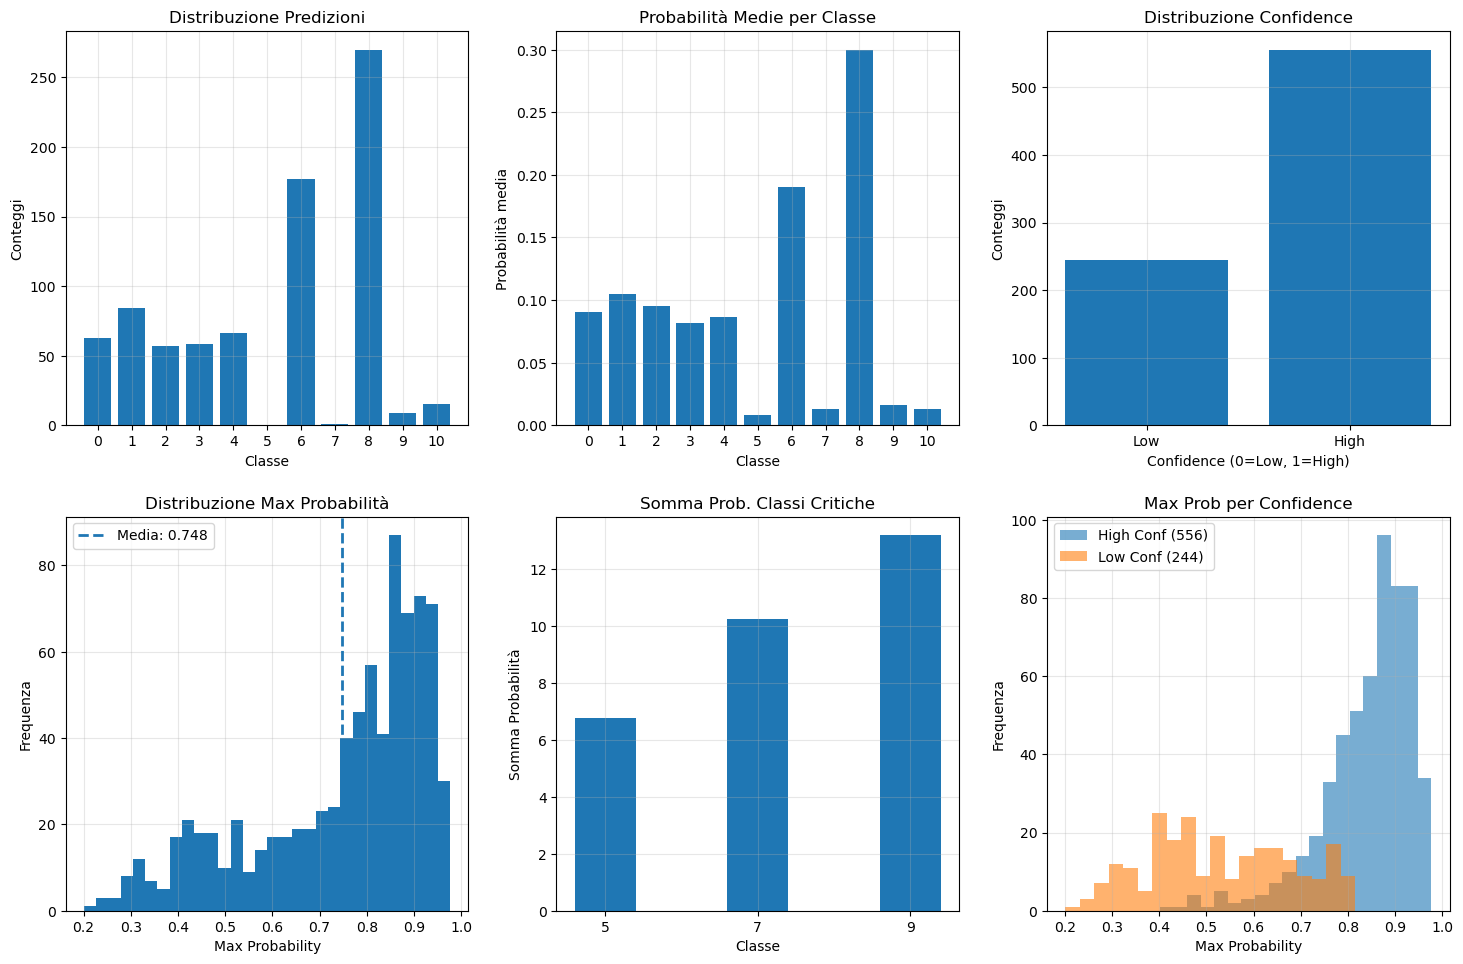

✅ Grafici visualizzati.


In [17]:
import utils.review_results
importlib.reload(utils.review_results)
from utils.review_results import analyze_submission, plot_submission  


y_pred, prob_sums = analyze_submission(submission_df)
plot_submission(submission_df, save_path=None)
